从一份良好的数据集中学习，训练过程中完全不更新数据

In [1]:
import torch


#封装数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        import numpy as np
        data = np.loadtxt('离线学习数据.txt')
        self.state = torch.FloatTensor(data[:, :3]).reshape(-1, 3)
        self.action = torch.FloatTensor(data[:, 3]).reshape(-1, 1)
        self.reward = torch.FloatTensor(data[:, 4]).reshape(-1, 1)
        self.next_state = torch.FloatTensor(data[:, 5:8]).reshape(-1, 3)
        self.over = torch.LongTensor(data[:, 8]).reshape(-1, 1)

    def __len__(self):
        return len(self.state)

    def __getitem__(self, i):
        return self.state[i], self.action[i], self.reward[i], self.next_state[
            i], self.over[i]


dataset = Dataset()

len(dataset), dataset[0]

(20000,
 (tensor([0.9019, 0.4320, 0.8704]),
  tensor([-1.5736]),
  tensor([0.9651]),
  tensor([0.8817, 0.4719, 0.8943]),
  tensor([0])))

In [2]:
#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=64,
                                     shuffle=True,
                                     drop_last=True)

len(loader)

312

In [3]:
import torch
from sac import SAC


#定义CQL算法
class CQL(SAC):

    def get_loss_cql(self, state, next_state, value):
        #把state,next_state复制5遍
        state = state.unsqueeze(dim=1).repeat(1, 5, 1).reshape(-1, 3)
        next_state = next_state.unsqueeze(1).repeat(1, 5, 1).reshape(-1, 3)

        #计算动作和熵
        rand_action = torch.empty([len(state), 1]).uniform_(-1, 1)
        curr_action, _ = self.get_action_entropy(state)
        next_action, _ = self.get_action_entropy(next_state)

        #计算三份动作分别的value
        value_rand = self.model_value(torch.cat([state, rand_action], dim=1))
        value_curr = self.model_value(torch.cat([state, curr_action], dim=1))
        value_next = self.model_value(torch.cat([state, next_action], dim=1))

        #拼合三份value
        value_cat = torch.cat([value_rand, value_curr, value_next], dim=1)
        loss_cat = value_cat.exp().sum(dim=1) + 1e-8
        loss_cat = loss_cat.log().mean()

        #在value loss上增加上这一部分
        return 5.0 * (loss_cat - value.mean())


cql = CQL()

cql

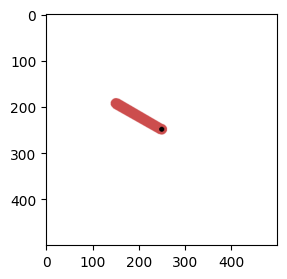

In [4]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #根据概率采样
        mu, sigma = cql.model_action(torch.FloatTensor(state).reshape(1, 3))
        action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

/root/miniconda3/envs/cuda117/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


49.54885690099563

In [6]:
def train():
    for epoch in range(200):
        for i, (state, action, reward, next_state, over) in enumerate(loader):
            cql.train_value(state, action, reward, next_state, over)
            cql.train_action(state)

        if epoch % 10 == 0:
            value = cql.model_value(torch.cat([state, action],
                                              dim=1)).mean().item()
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, value, test_result)


train()

0 2.21518611907959 9.759054348477896
10 14.770238876342773 57.34436458273679
20 22.05959129333496 35.228655545379
30 28.099075317382812 89.85440499866809
40 36.08259582519531 114.27782861153207
50 44.10224151611328 157.9843883786122
60 46.83131790161133 171.1354479880918
70 50.894508361816406 181.79026115481287
80 53.198081970214844 176.78876272448744
90 54.12747573852539 183.08075296407867
100 55.96063995361328 179.21220952184632
110 58.04907989501953 184.37389171490022
120 58.42814254760742 177.3067626818911
130 58.266326904296875 182.22527272364547
140 60.356361389160156 173.62140559932726
150 58.26789093017578 183.66146342147925
160 60.373321533203125 173.5510082565807
170 59.34394836425781 178.38124251421726
180 59.59429931640625 178.6704264063767
190 60.33028030395508 174.081362401392


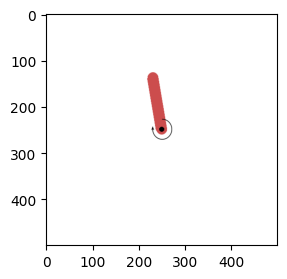

169.81928665726804

In [7]:
play(True)[-1]